Isaac Manjarrez Leyva
Algoritmo genetico

Importar librerias

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from enum import Enum

Clase cromosoma que maneja los genes, los cuales son la parte mas basica de un cromosoma, ademas implementa funciones para la manipualacion de los genes como lo es la normalizacion, calculo de riesgo, y calculo del rendimiento de el cromosoma

In [33]:
class Chromosome:
    def __init__(self):
        self.genes = np.array(self.__generate_random_genes())

    @staticmethod
    def __generate_random_genes():
        n = 10
        random_values = [random.random() for x in range(n)]
        summation = sum(random_values)
        return [x / summation for x in random_values]

    def normalize(self):
        self.genes = [x / sum(self.genes) for x in self.genes]

    def compute_risk(self, covariance):
        risk = 0
        for i in range(0, len(self.genes)):
            for j in range(0, len(self.genes)):
                risk += self.genes[i] * self.genes[j] * covariance[i][j]
        return risk

    def compute_chromosome_return(self, average_expected_returns):
        return sum([average_expected_returns[0][i] * self.genes[i] for i in range(len(
                average_expected_returns[0]))])

Clase portafolio, que maneja los datos de el portafolio, encargado de leer los activos del portafolio, calculo de retornos y calculo de retornos en promedio, ademas de guardar los resultados en variables

In [34]:
class PortfolioData:
    def __init__(self):
        self.assets = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Portafolio.csv')
        self.returns = pd.DataFrame(self.__compute_returns(), columns=self.assets.columns)
        self.average_expected_return = pd.DataFrame(self.__compute_average_expected_return(),
                                                    columns=self.assets.columns)
        self.covariance = np.cov(self.returns.to_numpy(copy=True), rowvar=False)

    def __compute_average_expected_return(self):
        returns = self.returns.to_numpy(copy=True)
        return np.array([[sum(returns[:, x]) / len(returns) for x in range(len(returns[0]))]])

    def __compute_returns(self):
        assets = self.assets.to_numpy(copy=True)
        returns = self.assets.to_numpy(copy=True)
        r = 1
        while r < len(returns):
            c = 0
            while c < len(returns[r]):
                returns[r][c] = (assets[r][c] - assets[r - 1][c]) / assets[r - 1][c]
                c += 1
            r += 1
        return returns[1:, ]

La clase population, la cual se encarga de manejar tanto el algoritmo genetico como el algoritmo genetico, aunque para este ejercicio solo se utilizan los metodos de el algoritmo genetico

In [35]:
class Population:
    def __init__(self, average_expected_returns, covariance):
        # Se almacenan los retornos en promedio
        self.average_expected_returns = average_expected_returns
        # se almacena la tabla se covarianza
        self.covariance = covariance
        # Se crea una poblacion de 100 cromosomas
        self.chromosomes = np.array([Chromosome() for i in range(100)])
        # se utiliza un array para el calculo del fitness
        self.fitness = np.array([])
        # Al iniciar se calcula el fitness
        self.__compute_fitness()
        # Se ordena la poblacion en base al fitness
        self.__sort()
    
    # Esta funcion genera la siguiente generacion de la poblacion usando el algoritmo genetico
    def next_generation(self):
        children = self.__select_by_tournament()
        self.__mutate(children)
        self.__replacement(children)
        self.__compute_fitness()
        self.__sort()
    
    # Esta funcion genera la siguente generacion de la poblacion usando el algoritmo diferencial
    def next_generation_by_differential_evolution(self):
        mutation_vectors = self.__generate_mutation_vectors()
        children = self.__differential_cross(mutation_vectors)
        self.__differential_replacement(children)
        self.__compute_fitness()
        self.__sort()
    
    # Remplazo usando el algoritmo diferencial
    def __differential_replacement(self, children):
        for chromosome_index in range(len(self.chromosomes)):
            if self.__target_function(children[chromosome_index]) > self.__target_function(
                    self.chromosomes[chromosome_index]):
                self.chromosomes[chromosome_index] = children[chromosome_index]

    # Retorna el valor de la funcion objetivo con un cromosoma especifico
    def __target_function(self, chromosome):
        numerator = chromosome.compute_chromosome_return(self.average_expected_returns)
        denominator = chromosome.compute_risk(self.covariance)
        return numerator / denominator

    # Genera los vectores de mutacion
    def __generate_mutation_vectors(self):
        mutation_vectors = np.array([])
        for i in range(len(self.chromosomes)):
            c1 = self.__select_different_chromosome_index([i])
            c2 = self.__select_different_chromosome_index([i, c1])
            f = random.random()
            mutation_vectors = np.append(mutation_vectors, [self.__generate_mutation_vector_de_current(i, c1, c2, f)])
        return mutation_vectors

    # Realiza la crusa en el algoritmo diferencial
    def __differential_cross(self, mutation_vectors):
        children = np.array([])
        for chromosome_index in range(len(self.chromosomes)):
            cr = random.random()
            new_child: Chromosome = Chromosome()
            for gen_index in range(len(self.chromosomes[chromosome_index].genes)):
                if random.random() == cr or \
                        random.randint(0, len(self.chromosomes[chromosome_index].genes)) == gen_index:
                    new_child.genes[gen_index] = mutation_vectors[chromosome_index].genes[gen_index]
                else:
                    new_child.genes[gen_index] = self.chromosomes[chromosome_index].genes[gen_index]
            new_child.normalize()
            children = np.append(children, [new_child])
        return children
    
    # Genera vectores de mutacion usando De/current
    def __generate_mutation_vector_de_current(self, current, c1, c2, f):
        mutation_vector = Chromosome()
        for i in range(len(mutation_vector.genes)):
            mutation_vector.genes[i] = abs(self.chromosomes[current].genes[i] + f * (self.chromosomes[c1].genes[i] -
                                                                                     self.chromosomes[c2].genes[i]))
        mutation_vector.normalize()
        return mutation_vector
    
    # Calcula el fitness de la poblacion
    def __compute_fitness(self):
        self.fitness = np.array([])
        for chromosome in self.chromosomes:
            self.fitness = np.append(self.fitness, [self.__target_function(chromosome)])
    
    # Ordena la poblacion en base al fitness
    def __sort(self):
        sorted_pairs = sorted(zip(self.fitness, self.chromosomes), key=lambda x: x[0])
        self.fitness = [i[0] for i in sorted_pairs]
        self.chromosomes = [i[1] for i in sorted_pairs]
    
    # Realiza la cruza en el algoritmo genetico
    def __cross(self, f1_index, f2_index, alpha):
        children1, children2 = Chromosome(), Chromosome()
        for i in range(len(children1.genes)):
            children1.genes[i] = \
                self.chromosomes[f1_index].genes[i] * (1 - alpha) + self.chromosomes[f2_index].genes[i] * alpha
            children2.genes[i] = \
                self.chromosomes[f2_index].genes[i] * (1 - alpha) + self.chromosomes[f1_index].genes[i] * alpha
        children1.normalize()
        children2.normalize()
        return [children1, children2]

    # Selecciona un indice que no este en la lista index_list
    def __select_different_chromosome_index(self, index_list: list):
        index2 = index_list[0]
        while index2 in index_list:
            index2 = random.randint(0, len(self.chromosomes) - 1)
        return index2

    # Realiza la seleccion por torneo
    def __select_by_tournament(self):
        children = np.array([])
        for i in range(40):
            alpha = random.random()
            f1_index = random.randint(0, len(self.chromosomes) - 1)
            f2_index = self.__select_different_chromosome_index([f1_index])
            f3_index = self.__select_different_chromosome_index([f1_index, f2_index])
            sorted_index_list = sorted([f1_index, f2_index, f3_index])
            f1_index = sorted_index_list[1]
            f2_index = sorted_index_list[2]
            children = np.append(children, self.__cross(f1_index, f2_index, alpha))
        return children
    
    # Realiza la mutacion en el algoritmo genetico
    @staticmethod
    def __mutate(children):
        mutation_population_size = random.randint(1, 4)
        mutation_index_list = np.random.choice([x for x in range(80)], mutation_population_size)
        for chromosome_index in mutation_index_list:
            children[chromosome_index].genes[random.randint(0, 9)] = random.random()
            children[chromosome_index].normalize()
    
    # Realiza el remplazo en el algoritmo genetico
    def __replacement(self, children):
        i = 0
        while i < 80:
            self.chromosomes[i] = children[i]
            i += 1

Se crea el portafolio 

In [36]:
portfolio = PortfolioData()

Se muestran los activos

In [37]:
print(portfolio.assets.to_string())

      Sony    Amazon  Mercado libre    Intel     AMD  Agilent Technologies  Microsoft  Activision Blizzard  Ubisoft Entertainment  Spotify Technology
0   111.79  67800.00       19700.01  1364.00   82.76                131.91    5134.82              1930.00                1364.50             5560.00
1    97.40  63819.55       27687.93  1113.99   75.99                131.87    4940.09              1880.00                1414.68             4551.55
2    98.60  65685.54       27100.00  1142.99   81.56                143.06    5059.03              1904.64                1394.91             4850.00
3   102.04  73712.58       30760.00  1117.56   90.90                150.03    5513.50              1835.00                1309.40             5164.88
4   100.88  66689.47       37490.00  1084.34  106.48                156.52    5740.66              1667.32                1230.08             4336.19
5   110.32  69100.00       30467.50  1083.99  105.20                177.23    5887.84              1

Se muestran los retornos

In [38]:
print(portfolio.returns.to_string())

        Sony    Amazon  Mercado libre     Intel       AMD  Agilent Technologies  Microsoft  Activision Blizzard  Ubisoft Entertainment  Spotify Technology
0  -0.128723 -0.058709       0.405478 -0.183292 -0.081803             -0.000303  -0.037923            -0.025907               0.036775           -0.181376
1   0.012320  0.029239      -0.021234  0.026033  0.073299              0.084856   0.024076             0.013106              -0.013975            0.065571
2   0.034888  0.122204       0.135055 -0.022249  0.114517              0.048721   0.089833            -0.036563              -0.061301            0.064924
3  -0.011368 -0.095277       0.218791 -0.029725  0.171397              0.043258   0.041201            -0.091379              -0.060577           -0.160447
4   0.093577  0.036146      -0.187317 -0.000323 -0.012021              0.132315   0.025638            -0.049001               0.074727            0.141943
5  -0.010606 -0.017366       0.070649  0.032297 -0.004943             

Se muestran los retornos promedio

In [39]:
print(portfolio.average_expected_return.to_string())

       Sony   Amazon  Mercado libre     Intel       AMD  Agilent Technologies  Microsoft  Activision Blizzard  Ubisoft Entertainment  Spotify Technology
0 -0.080418 -0.00209       0.319441 -0.027833  0.030834              0.004649   0.015857            -0.006573              -0.032608           -0.050585


Se crea la poblacion

In [40]:
population: Population = Population(portfolio.average_expected_return.to_numpy(copy=True), portfolio.covariance)

Se muestra el mejor valor de al primera generacion

In [41]:
print(population.fitness[-1])

7.613731179261558


Se realizan las iteracion por convergencia en 500

In [42]:
best_fitness_history = [population.fitness[-1]]
convergence_iterations = 500
current_iterations = convergence_iterations
while current_iterations > 0:
    population.next_generation()
    best_fitness_history.append(population.fitness[-1])
    if best_fitness_history[-1] == best_fitness_history[-2]:
        current_iterations -= 1
    else:
        current_iterations = convergence_iterations

Se muestra el mejor valor obtenido al finalizar las iteraciones

In [43]:
print(best_fitness_history[-1])

19.23808852339548


Se muestra un historial de el mejor en cada iteracion

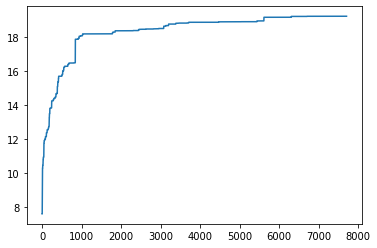

In [44]:
plt.plot([i for i in range(len(best_fitness_history))], best_fitness_history)
plt.show()

Se muestran los valores a imprimir en cada compañia

In [45]:
print(pd.DataFrame([population.chromosomes[-1].genes], columns=portfolio.assets.columns).to_string())

       Sony    Amazon  Mercado libre     Intel       AMD  Agilent Technologies  Microsoft  Activision Blizzard  Ubisoft Entertainment  Spotify Technology
0  0.099388  0.000048       0.064183  0.012173  0.000233              0.000514   0.454916             0.141877               0.226473            0.000194


Se muestra graficamente los valores a imprimir

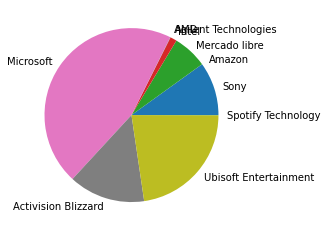

In [46]:
plt.pie(population.chromosomes[-1].genes, labels=portfolio.assets.columns)
plt.show()

Finalmente se muestra una tabla comparando el riesgo y el retorno esperado

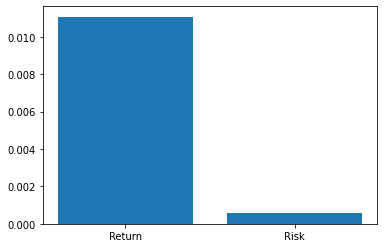

In [47]:
chromosome_return = population.chromosomes[-1].compute_chromosome_return(
        portfolio.average_expected_return.to_numpy())
chromosome_risk = population.chromosomes[-1].compute_risk(portfolio.covariance)
plt.bar(['Return', 'Risk'], [chromosome_return, chromosome_risk])
plt.show()